### Reimplementation of Image Super-Resolution Using Deep Convolutional Network in PyTorch

This notebook is the reimplementation of this [paper](https://arxiv.org/abs/1501.00092)

In [2]:
import os
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import to_pil_image
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToPILImage

torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load dataset

In [3]:
class MyDataset(Dataset):
    def __init__(self, file_path):
        self.file = h5py.File(file_path, 'r')
        self.input = self.file['data']
        self.target = self.file['label']
        
    def __len__(self):
        return len(self.input)
    
    def __getitem__(self,idx):
        input = torch.tensor(self.input[idx], dtype=torch.float32)
        target = torch.tensor(self.target[idx], dtype=torch.float32)
        
        return input, target
    
    def close(self):
        self.file.close()       

### Visualizing the dataset input and target

Image input size:  torch.Size([3, 33, 33])


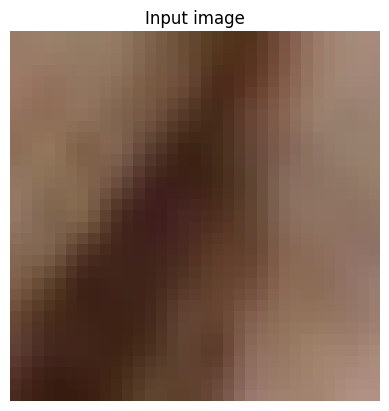

Image target size:  torch.Size([3, 21, 21])


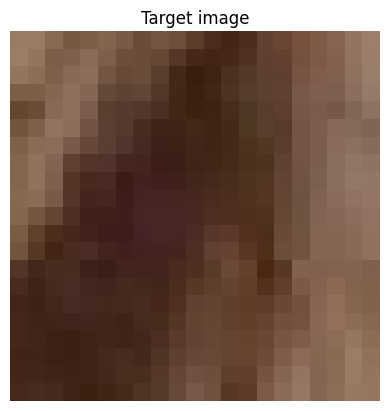

In [4]:
# Create an instance of MyDataset
dataset = MyDataset('train.h5')

index_to_print = 4

input, target = dataset[index_to_print]

print("Image input size: ", input.size())

pil_input = to_pil_image(input)
pil_target = to_pil_image(target)


plt.imshow(pil_input)
plt.title("Input image")
plt.axis('off')
plt.show()

print("Image target size: ", target.size())

plt.title("Target image")
plt.imshow(pil_target)
plt.axis('off')
plt.show()
dataset.close()

### Preparing Datasets and Dataloaders

The train.h5 and test.h5 files are obtained by running the MATLAB scripts generate_train and generate_test respectively from [this](https://mmlab.ie.cuhk.edu.hk/projects/SRCNN/SRCNN_train.zip) source code given in the original paper

In [5]:
# Define dataset and dataloader
dataset = MyDataset('train.h5') 
train_loader = DataLoader(dataset, batch_size=128)

dataset_test_set5 = MyDataset('test.h5')
val_loader = DataLoader(dataset_test_set5, batch_size=128)

### Defining the CNN model

In [6]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4)
        self.relu1 = nn.ReLU(True)
        
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU(True)
        
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, stride=1, padding=2)
        
    def forward(self, x):
        out = self.relu1(self.conv1(x))
        out = self.relu2(self.conv2(out))
        out = self.conv3(out)
        return out[:, :, 6:-6, 6:-6]  # Crop the output to match the size 21x21

### Setting hyperparameters

In [7]:
model = SRCNN()
criterion = nn.SmoothL1Loss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
num_epochs = 20

### Training loop

In [85]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print average loss after each epoch
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

print("Training complete!")

# Save the trained model
torch.save(model.state_dict(), 'srcnn_model.pth')

Epoch 1, Loss: 0.02094374546123778
Epoch 2, Loss: 0.008470749055199763
Epoch 3, Loss: 0.0049471864846589815
Epoch 4, Loss: 0.0037831278531538213
Epoch 5, Loss: 0.0033041357596897904
Epoch 6, Loss: 0.0030716950183405597
Epoch 7, Loss: 0.0029152756707523674
Epoch 8, Loss: 0.0027856660349404113
Epoch 9, Loss: 0.002671976130017463
Epoch 10, Loss: 0.0025706994265098783
Epoch 11, Loss: 0.002480260084848851
Epoch 12, Loss: 0.0023996206678395323
Epoch 13, Loss: 0.0023277091793715956
Epoch 14, Loss: 0.0022635817034717867
Epoch 15, Loss: 0.0022064596743268127
Epoch 16, Loss: 0.0021557501537780113
Epoch 17, Loss: 0.002110858623842325
Epoch 18, Loss: 0.002071175185333499
Epoch 19, Loss: 0.002036075954161146
Epoch 20, Loss: 0.002004984176635523
Training complete!


### Test validation loss using validation loader

In [8]:
to_pil_image = ToPILImage()

# Evaluate model on validation dataset
model.eval()
val_loss = 0.0

with torch.no_grad():
    for batch_idx, (val_inputs, val_labels) in enumerate(val_loader):
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        
        val_outputs = model(val_inputs)
        
        val_loss += criterion(val_outputs, val_labels).item()
    
    # Calculate average validation loss
    average_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {average_val_loss}")

Validation Loss: 0.14188301004469395


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


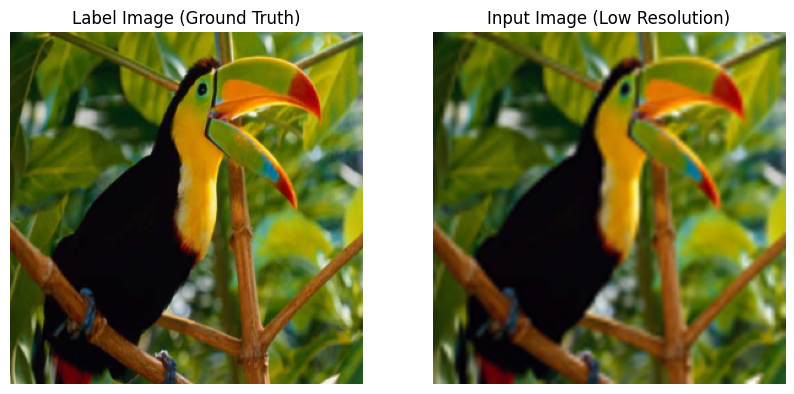

In [10]:
# Function to modcrop the image
def modcrop(img, scale):
    h, w = img.shape[1], img.shape[2] # img = torch.Size([3, 33, 33])
    h = h - (h % scale)
    w = w - (w % scale)
    img = img[:, :h, :w]
    return img

input_image_path = 'bird_GT.bmp'
input_image = Image.open(input_image_path).convert('RGB')

# Convert the image to tensor
input_image = TF.to_tensor(input_image).float()  # Change to float

scale = 3

# Process image for label and input
im_label = modcrop(input_image, scale)
im_input = TF.resize(im_label, [im_label.shape[1] // scale, im_label.shape[2] // scale], interpolation=TF.InterpolationMode.BICUBIC)
im_input = TF.resize(im_input, [im_label.shape[1], im_label.shape[2]], interpolation=TF.InterpolationMode.BICUBIC)

# Display the label image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(im_label.permute(1, 2, 0))
plt.title('Label Image (Ground Truth)')
plt.axis('off')

# Display the input image
plt.subplot(1, 2, 2)
plt.imshow(im_input.permute(1, 2, 0))
plt.title('Input Image (Low Resolution)')
plt.axis('off')

plt.show()

### Extract patches from the input image

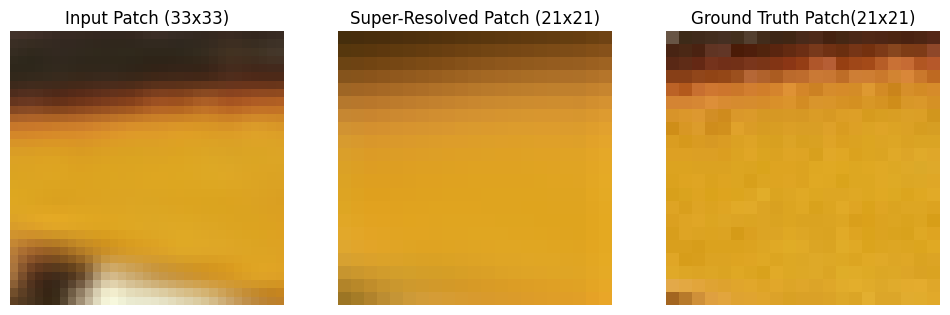

In [88]:
input_patch_size = 33
output_patch_size = 21
stride = 14

data = []
label = []
padding = (input_patch_size - output_patch_size) // 2

for y in range(0, im_label.shape[1] - input_patch_size + 1, stride):
    for x in range(0, im_label.shape[2] - input_patch_size + 1, stride):
        # Extract input and label patches
        subim_input = im_input[:, y:y + input_patch_size, x:x + input_patch_size]
        subim_label = im_label[:, y + padding:y + padding + output_patch_size, x + padding:x + padding + output_patch_size]

        data.append(subim_input)
        label.append(subim_label)

# Convert lists of tensors to batch tensors
data = torch.stack(data).float()  # Change to float
label = torch.stack(label).float()  # Change to float

model = SRCNN()
model.load_state_dict(torch.load('srcnn_model.pth'))
model.eval()

# Perform inference on the input patches using the model
with torch.no_grad():
    output_batch = model(data)

# Visualize a specific output patch
patch_index = 23  # Example patch index to visualize

# Convert tensors to PIL images
input_patch_tensor = data[patch_index].detach().cpu()
label_patch_tensor = label[patch_index].detach().cpu()
output_patch_tensor = output_batch[patch_index].detach().cpu()

input_patch_pil = TF.to_pil_image(input_patch_tensor)
label_patch_pil = TF.to_pil_image(label_patch_tensor)
output_patch_pil = TF.to_pil_image(output_patch_tensor)

# Display the input patch, label patch (ground truth), and the model's output (super-resolved patch)
plt.figure(figsize=(12, 4))

# Display input patch
plt.subplot(1, 3, 1)
plt.imshow(input_patch_pil)
plt.title('Input Patch (33x33)')
plt.axis('off')

# Display output patch (super-resolved)
plt.subplot(1, 3, 2)
plt.imshow(output_patch_pil)
plt.title('Super-Resolved Patch (21x21)')
plt.axis('off')

# Display label patch (ground truth)
plt.subplot(1, 3, 3)
plt.imshow(label_patch_pil)
plt.title('Ground Truth Patch(21x21)')
plt.axis('off')

plt.show()

### Testing the images and store results in /results directory (output patch size match input patch size using bicubic interpolation)

In [89]:
# Ensure results directory exists
os.makedirs("results", exist_ok=True)

# Load the trained SRCNN model
model = SRCNN()
model.load_state_dict(torch.load("srcnn_model.pth"))
model.eval()

# Directories containing the images
directories = ["data/Test/Set5", "data/Test/Set14"]

# Process each image in the directories
for directory in directories:
    for filename in os.listdir(directory):
        if filename.endswith(".bmp"):
            input_image_path = os.path.join(directory, filename)

            # Load the input image
            input_image = Image.open(input_image_path).convert("RGB")

            # Convert the image to tensor
            input_image = TF.to_tensor(input_image).float()

            # Define patch size and stride
            input_patch_size = 33
            output_patch_size = 21
            scale = 3
            stride = 14

            # Process image for label and input
            im_label = modcrop(input_image, scale)
            im_input = TF.resize(im_label, [im_label.shape[1] // scale, im_label.shape[2] // scale], interpolation=TF.InterpolationMode.BICUBIC)
            im_input = TF.resize(im_input, [im_label.shape[1], im_label.shape[2]], interpolation=TF.InterpolationMode.BICUBIC)

            # Extract patches from the input image
            patches = []
            coords = []
            image_width, image_height = im_input.shape[2], im_input.shape[1]

            for y in range(0, image_height - input_patch_size + 1, stride):
                for x in range(0, image_width - input_patch_size + 1, stride):
                    # Crop input patch from the image
                    input_patch = im_input[:, y:y + input_patch_size, x:x + input_patch_size]
                    patches.append(input_patch)
                    coords.append((x, y))

            # Handle the right and bottom edges
            for y in range(0, image_height - input_patch_size + 1, stride):
                input_patch = im_input[:, y:y + input_patch_size, image_width - input_patch_size:image_width]
                patches.append(input_patch)
                coords.append((image_width - input_patch_size, y))

            for x in range(0, image_width - input_patch_size + 1, stride):
                input_patch = im_input[:, image_height - input_patch_size:image_height, x:x + input_patch_size]
                patches.append(input_patch)
                coords.append((x, image_height - input_patch_size))

            input_patch = im_input[:, image_height - input_patch_size:image_height, image_width - input_patch_size:image_width]
            patches.append(input_patch)
            coords.append((image_width - input_patch_size, image_height - input_patch_size))

            # Convert list of tensors to a batch tensor
            input_batch = torch.stack(patches).float()

            # Perform inference on the input patches using the model
            with torch.no_grad():
                output_batch = model(input_batch)

            # Initialize an empty tensor for the output image
            output_image = torch.zeros(3, image_height, image_width)
            
            # Initialize an empty tensor to count overlapping regions 
            overlap_count = torch.zeros(image_height, image_width)

            # Place each output patch back into the correct location in the output image
            for i, (x, y) in enumerate(coords):
                output_patch = output_batch[i]
                
                # Resize the output patch to the size of the input patch
                output_patch_resized = F.interpolate(output_patch.unsqueeze(0), size=(input_patch_size, input_patch_size), mode='bicubic').squeeze(0)
                
                # Place the resized output patch into the correct location in the output image
                output_image[:, y:y + input_patch_size, x:x + input_patch_size] += output_patch_resized
                overlap_count[y:y + input_patch_size, x:x + input_patch_size] += 1

            # Average overlapping regions
            output_image /= overlap_count

            # Convert the output image tensor to a PIL image
            output_image_pil = TF.to_pil_image(output_image.clamp(0, 1))

            # Save the output image
            result_image_name = os.path.basename(filename).replace("_GT.bmp", "_SR.bmp")
            output_image_pil.save(os.path.join("results", result_image_name))

            print(f"Processed {filename} and saved result as {result_image_name}")


Processed baby_GT.bmp and saved result as baby_SR.bmp
Processed bird_GT.bmp and saved result as bird_SR.bmp
Processed butterfly_GT.bmp and saved result as butterfly_SR.bmp
Processed head_GT.bmp and saved result as head_SR.bmp
Processed woman_GT.bmp and saved result as woman_SR.bmp
Processed baboon.bmp and saved result as baboon.bmp
Processed barbara.bmp and saved result as barbara.bmp
Processed bridge.bmp and saved result as bridge.bmp
Processed coastguard.bmp and saved result as coastguard.bmp
Processed comic.bmp and saved result as comic.bmp
Processed face.bmp and saved result as face.bmp
Processed flowers.bmp and saved result as flowers.bmp
Processed foreman.bmp and saved result as foreman.bmp
Processed lenna.bmp and saved result as lenna.bmp
Processed man.bmp and saved result as man.bmp
Processed monarch.bmp and saved result as monarch.bmp
Processed pepper.bmp and saved result as pepper.bmp
Processed ppt3.bmp and saved result as ppt3.bmp
Processed zebra.bmp and saved result as zebr

### Testing the images and store results in /results directory (output patch size does not match input patch size)

In [91]:
os.makedirs("results", exist_ok=True)

# Load the trained SRCNN model
model = SRCNN()
model.load_state_dict(torch.load("srcnn_model.pth"))
model.eval()

# Directories containing the images
directories = ["data/Test/Set5", "data/Test/Set14"]

# Process each image in the directories
for directory in directories:
    for filename in os.listdir(directory):
        if filename.endswith(".bmp"):
            input_image_path = os.path.join(directory, filename)

            # Load the input image
            input_image = Image.open(input_image_path).convert("RGB")

            # Convert the image to tensor
            input_image = TF.to_tensor(input_image).float()

            # Define patch size and stride
            input_patch_size = 33
            output_patch_size = 21
            scale = 3
            stride = 14

            # Process image for label and input
            im_label = modcrop(input_image, scale)
            im_input = TF.resize(im_label, [im_label.shape[1] // scale, im_label.shape[2] // scale], interpolation=TF.InterpolationMode.BICUBIC)
            im_input = TF.resize(im_input, [im_label.shape[1], im_label.shape[2]], interpolation=TF.InterpolationMode.BICUBIC)

            # Extract patches from the input image
            patches = []
            coords = []
            image_width, image_height = im_input.shape[2], im_input.shape[1]

            for y in range(0, image_height - input_patch_size + 1, stride):
                for x in range(0, image_width - input_patch_size + 1, stride):
                    # Crop input patch from the image
                    input_patch = im_input[:, y:y + input_patch_size, x:x + input_patch_size]
                    patches.append(input_patch)
                    coords.append((x, y))

            # Handle the right and bottom edges
            for y in range(0, image_height - input_patch_size + 1, stride):
                input_patch = im_input[:, y:y + input_patch_size, image_width - input_patch_size:image_width]
                patches.append(input_patch)
                coords.append((image_width - input_patch_size, y))

            for x in range(0, image_width - input_patch_size + 1, stride):
                input_patch = im_input[:, image_height - input_patch_size:image_height, x:x + input_patch_size]
                patches.append(input_patch)
                coords.append((x, image_height - input_patch_size))

            input_patch = im_input[:, image_height - input_patch_size:image_height, image_width - input_patch_size:image_width]
            patches.append(input_patch)
            coords.append((image_width - input_patch_size, image_height - input_patch_size))

            # Convert list of tensors to a batch tensor
            input_batch = torch.stack(patches).float()

            # Perform inference on the input patches using the model
            with torch.no_grad():
                output_batch = model(input_batch)

            # Initialize an empty tensor for the output image
            output_image = torch.zeros(3, image_height, image_width)

            # Initialize an empty tensor to count overlapping regions
            overlap_count = torch.zeros(image_height, image_width)

            # Place each output patch back into the correct location in the output image
            for i, (x, y) in enumerate(coords):
                output_patch = output_batch[i]
                output_image[:, y:y + output_patch_size, x:x + output_patch_size] += output_patch
                overlap_count[y:y + output_patch_size, x:x + output_patch_size] += 1

            # Average overlapping regions
            output_image /= overlap_count

            # Convert the output image tensor to a PIL image
            output_image_pil = TF.to_pil_image(output_image.clamp(0, 1))

            # Save the output image
            result_image_name = os.path.basename(filename).replace("_GT.bmp", "_SR.bmp")
            output_image_pil.save(os.path.join("results", result_image_name))

            print(f"Processed {filename} and saved result as {result_image_name}")


Processed baby_GT.bmp and saved result as baby_SR.bmp
Processed bird_GT.bmp and saved result as bird_SR.bmp
Processed butterfly_GT.bmp and saved result as butterfly_SR.bmp
Processed head_GT.bmp and saved result as head_SR.bmp
Processed woman_GT.bmp and saved result as woman_SR.bmp
Processed baboon.bmp and saved result as baboon.bmp
Processed barbara.bmp and saved result as barbara.bmp
Processed bridge.bmp and saved result as bridge.bmp
Processed coastguard.bmp and saved result as coastguard.bmp
Processed comic.bmp and saved result as comic.bmp
Processed face.bmp and saved result as face.bmp
Processed flowers.bmp and saved result as flowers.bmp
Processed foreman.bmp and saved result as foreman.bmp
Processed lenna.bmp and saved result as lenna.bmp
Processed man.bmp and saved result as man.bmp
Processed monarch.bmp and saved result as monarch.bmp
Processed pepper.bmp and saved result as pepper.bmp
Processed ppt3.bmp and saved result as ppt3.bmp
Processed zebra.bmp and saved result as zebr

### View an image results for comparison (output patch size does not match input patch size)

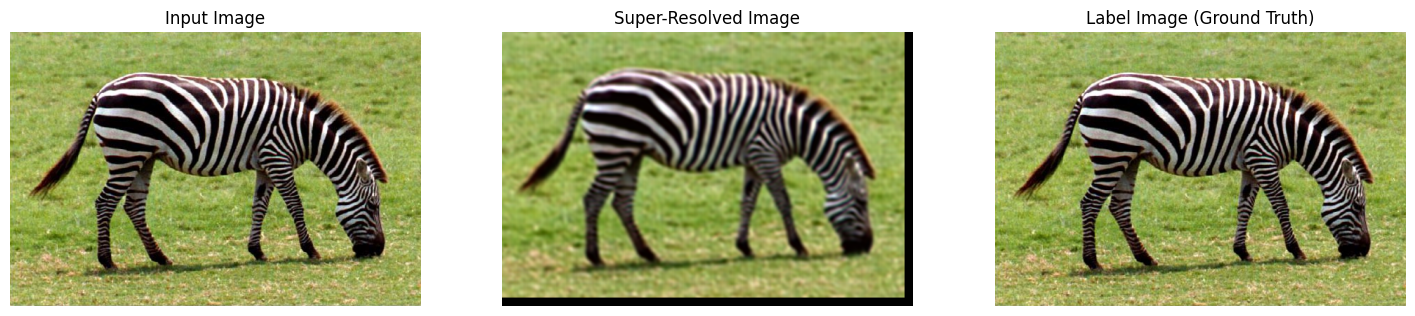

In [92]:
input_image_path = "zebra.bmp"
input_image = Image.open(input_image_path).convert("RGB")

# Convert the image to tensor
input_image = TF.to_tensor(input_image).float()

# Define patch size and stride
input_patch_size = 33
output_patch_size = 21
scale = 3
stride = 14

# Process image for label and input
im_label = modcrop(input_image, scale)
im_input = TF.resize(im_label, [im_label.shape[1] // scale, im_label.shape[2] // scale], interpolation=TF.InterpolationMode.BICUBIC)
im_input = TF.resize(im_input, [im_label.shape[1], im_label.shape[2]], interpolation=TF.InterpolationMode.BICUBIC)

# Extract patches from the input image
patches = []
coords = []
image_width, image_height = im_input.shape[2], im_input.shape[1]

for y in range(0, image_height - input_patch_size + 1, stride):
    for x in range(0, image_width - input_patch_size + 1, stride):
        # Crop input patch from the image
        input_patch = im_input[:, y:y + input_patch_size, x:x + input_patch_size]
        patches.append(input_patch)
        coords.append((x, y))

# Handle the right and bottom edges
for y in range(0, image_height - input_patch_size + 1, stride):
    input_patch = im_input[:, y:y + input_patch_size, image_width - input_patch_size:image_width]
    patches.append(input_patch)
    coords.append((image_width - input_patch_size, y))

for x in range(0, image_width - input_patch_size + 1, stride):
    input_patch = im_input[:, image_height - input_patch_size:image_height, x:x + input_patch_size]
    patches.append(input_patch)
    coords.append((x, image_height - input_patch_size))

input_patch = im_input[:, image_height - input_patch_size:image_height, image_width - input_patch_size:image_width]
patches.append(input_patch)
coords.append((image_width - input_patch_size, image_height - input_patch_size))

# Convert list of tensors to a batch tensor
input_batch = torch.stack(patches).float()

# Load the trained SRCNN model
model = SRCNN()
model.load_state_dict(torch.load("srcnn_model.pth"))
model.eval()

# Perform inference on the input patches using the model
with torch.no_grad():
    output_batch = model(input_batch)

# Initialize an empty tensor for the output image
output_image = torch.zeros(3, image_height, image_width)

# Initialize an empty tensor to count overlapping regions
overlap_count = torch.zeros(image_height, image_width)

# Place each output patch back into the correct location in the output image
for i, (x, y) in enumerate(coords):
    output_patch = output_batch[i]
    output_image[:, y:y + output_patch_size, x:x + output_patch_size] += output_patch
    overlap_count[y:y + output_patch_size, x:x + output_patch_size] += 1

# Average overlapping regions
output_image /= overlap_count

# Convert the output image tensor to a PIL image
output_image_pil = TF.to_pil_image(output_image.clamp(0, 1))

# Display the input image, label image, and the super-resolved image
plt.figure(figsize=(18, 6))

# Display input image
plt.subplot(1, 3, 1)
input_image_pil = TF.to_pil_image(input_image)
plt.imshow(input_image_pil)
plt.title("Input Image")
plt.axis("off")

# Display super-resolved image
plt.subplot(1, 3, 2)
plt.imshow(output_image_pil)
plt.title("Super-Resolved Image")
plt.axis("off")

# Display label image
plt.subplot(1, 3, 3)
label_image_pil = TF.to_pil_image(im_label)
plt.imshow(label_image_pil)
plt.title("Label Image (Ground Truth)")
plt.axis("off")

plt.show()

### View an image results for comparison (output patch size match input patch size using bicubic interpolation)

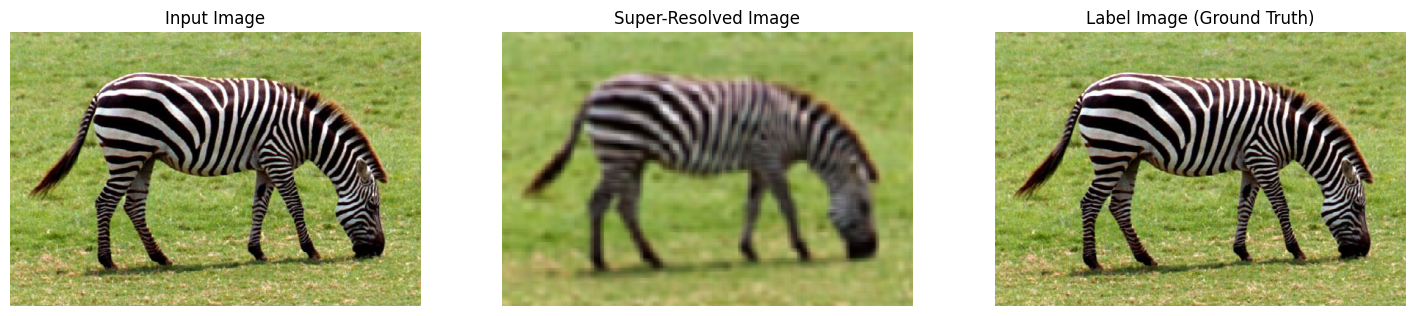

In [90]:
# Load the input image
input_image_path = "zebra.bmp"
input_image = Image.open(input_image_path).convert("RGB")

# Convert the image to tensor
input_image = TF.to_tensor(input_image).float()

# Define patch size and stride
input_patch_size = 33
output_patch_size = 21
scale = 3
stride = 14

# Process image for label and input
im_label = modcrop(input_image, scale)
im_input = TF.resize(im_label, [im_label.shape[1] // scale, im_label.shape[2] // scale], interpolation=TF.InterpolationMode.BICUBIC)
im_input = TF.resize(im_input, [im_label.shape[1], im_label.shape[2]], interpolation=TF.InterpolationMode.BICUBIC)

# Extract patches from the input image
patches = []
coords = []
image_width, image_height = im_input.shape[2], im_input.shape[1]

for y in range(0, image_height - input_patch_size + 1, stride):
    for x in range(0, image_width - input_patch_size + 1, stride):
        # Crop input patch from the image
        input_patch = im_input[:, y:y + input_patch_size, x:x + input_patch_size]
        patches.append(input_patch)
        coords.append((x, y))

# Handle the right and bottom edges
for y in range(0, image_height - input_patch_size + 1, stride):
    input_patch = im_input[:, y:y + input_patch_size, image_width - input_patch_size:image_width]
    patches.append(input_patch)
    coords.append((image_width - input_patch_size, y))

for x in range(0, image_width - input_patch_size + 1, stride):
    input_patch = im_input[:, image_height - input_patch_size:image_height, x:x + input_patch_size]
    patches.append(input_patch)
    coords.append((x, image_height - input_patch_size))

input_patch = im_input[:, image_height - input_patch_size:image_height, image_width - input_patch_size:image_width]
patches.append(input_patch)
coords.append((image_width - input_patch_size, image_height - input_patch_size))

# Convert list of tensors to a batch tensor
input_batch = torch.stack(patches).float()

# Load the trained SRCNN model
model = SRCNN()
model.load_state_dict(torch.load("srcnn_model.pth"))
model.eval()

# Perform inference on the input patches using the model
with torch.no_grad():
    output_batch = model(input_batch)

# Define the output patch size
output_patch_size = 33

# Initialize an empty tensor for the output image
output_image = torch.zeros(3, image_height, image_width)

# Initialize an empty tensor to count overlapping regions
overlap_count = torch.zeros(image_height, image_width)

# Place each output patch back into the correct location in the output image
for i, (x, y) in enumerate(coords):
    output_patch = output_batch[i]
    
    # Resize the output patch to match the size of the input patch
    resized_output_patch = F.interpolate(output_patch.unsqueeze(0), size=(output_patch_size, output_patch_size), mode='bicubic').squeeze(0)
    
    # Place the resized output patch into the correct location in the output image
    output_image[:, y:y + output_patch_size, x:x + output_patch_size] += resized_output_patch
    overlap_count[y:y + output_patch_size, x:x + output_patch_size] += 1

# Average overlapping regions
output_image /= overlap_count


# Convert the output image tensor to a PIL image
output_image_pil = TF.to_pil_image(output_image.clamp(0, 1))

# Display the input image, label image, and the super-resolved image
plt.figure(figsize=(18, 6))

# Display input image
plt.subplot(1, 3, 1)
input_image_pil = TF.to_pil_image(input_image)
plt.imshow(input_image_pil)
plt.title("Input Image")
plt.axis("off")

# Display super-resolved image
plt.subplot(1, 3, 2)
plt.imshow(output_image_pil)
plt.title("Super-Resolved Image")
plt.axis("off")

# Display label image
plt.subplot(1, 3, 3)
label_image_pil = TF.to_pil_image(im_label)
plt.imshow(label_image_pil)
plt.title("Label Image (Ground Truth)")
plt.axis("off")

plt.show()
